In [30]:
!pip freeze | grep "qiskit"

qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2


In [31]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit_aer.noise import NoiseModel, ReadoutError
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram

from numpy import sqrt, dot, kron, array, diag, pi
from numpy.random import default_rng
from numpy.linalg import inv

In [32]:
def build_qaoa_circuit(
    num_qubits: int,
    depth: int,
    *,
    measurements: bool = True,
    barriers: bool = False,
) -> QuantumCircuit:
    """Build parameterized QAOA quantum circuit.

    Args:
        num_qubits: number of qubits.
        depth: two-qubit depth (needs to be even).
        measurements: if True adds measurements at the end.
        barriers: if True adds barriers between layers.
    Returns:
        A dense QAOA quantum circuit for a linear, non-cyclic, graph
        with cost parameter-vector γ, and mixer parameter-vector β.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if depth % 2 != 0:
        raise ValueError("Depth must be even.")

    gammas = ParameterVector("γ", depth // 2)
    betas = ParameterVector("β", depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            circuit.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    if measurements:
        circuit.measure_all()
    return circuit


def produce_qaoa_parameters(num_layers, *, seed=None):
    """Produce random QAOA parameters.
    Args:
        num_layers: the number of QAOA layers.
        seed: a seed to generate the random angles.
    Returns:
        A tuple holding the beta and gamma angles.
    """
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()
    return betas, gammas


def build_compute_uncompute_qaoa_circuit(
    num_qubits: int,
    depth: int,
    *,
    measurements: bool = True,
    barriers: bool = False,
) -> QuantumCircuit:
    """Build a parametrized compute-uncompute QAOA quantum circuit."""
    if depth % 4 != 0:
        raise ValueError("Depth must be a multiple of four.")

    qaoa = build_qaoa_circuit(
        num_qubits, depth // 2, measurements=False, barriers=barriers
    )

    circuit = QuantumCircuit(num_qubits)
    circuit.compose(qaoa, inplace=True)
    circuit.barrier()
    circuit.compose(qaoa.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)

    return circuit

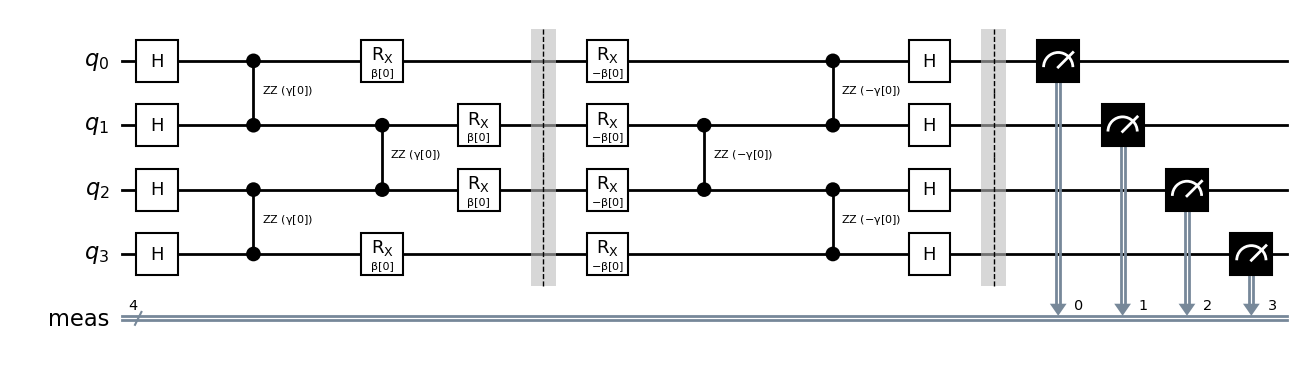

In [33]:
qc = build_compute_uncompute_qaoa_circuit(4, 4)
qc.draw("mpl", style="bw", fold=-1)

In [34]:
betas, gammas = produce_qaoa_parameters(1)
params = [gammas[0], betas[0]]
params

[1.5476870427777474, 1.3835091559739343]

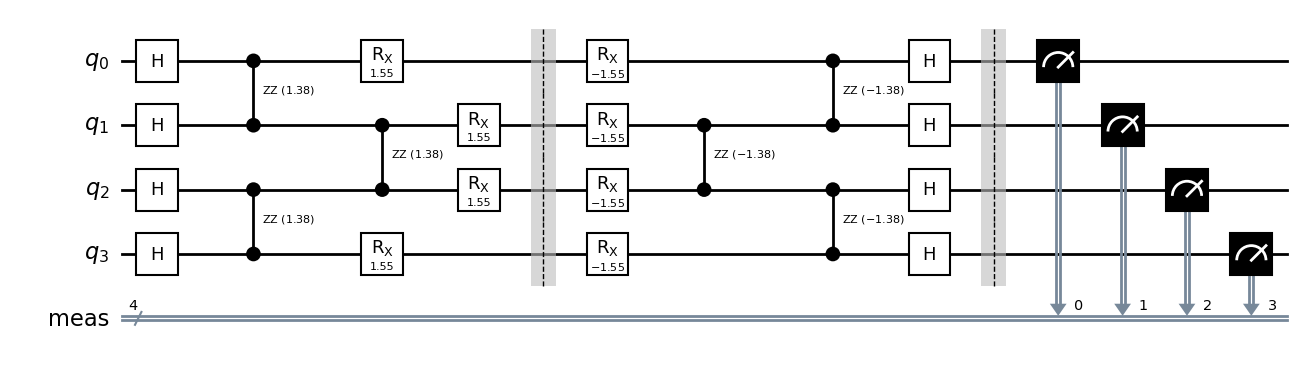

In [35]:
qc = qc.assign_parameters(params)
qc.draw("mpl", style="bw", fold=-1)

In [36]:
shots = 10000
observables = [
    "ZIII",
    "IZII",
    "IIZI",
    "IIIZ",
    "ZZII",
    "IZZI",
    "IIZZ",
    "ZZZI",
    "IZZZ",
    "ZZZZ",
]

### First we create our noisy measurement

In [37]:
def create_measurement_error(p0g1: float, p1g0: float) -> NoiseModel:
    noise_model = NoiseModel()
    noise_model.add_all_qubit_readout_error([[1 - p1g0, p1g0], [p0g1, 1 - p0g1]])
    return noise_model

In [38]:
noise_model = create_measurement_error(0.2, 0.1)
simulator = AerSimulator(noise_model=noise_model)

#### Test the noise model

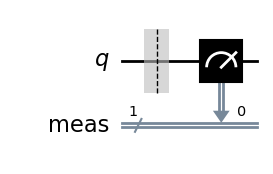

In [39]:
test = QuantumCircuit(1)
test.measure_all()
test.draw("mpl", style="bw")

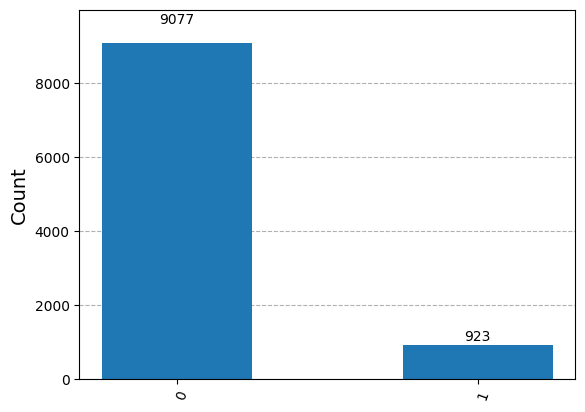

In [40]:
counts_test = simulator.run(test, shots=shots).result().get_counts()
plot_histogram(counts_test)

### Now we create the A matrix

In order to create the A matrix, we can run calibration experiments by preparing the qubit once in $|0\rangle$ and then in $|1\rangle$.

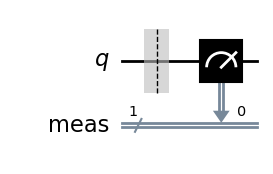

In [41]:
cal0 = QuantumCircuit(1)
cal0.measure_all()
cal0.draw("mpl", style="bw")

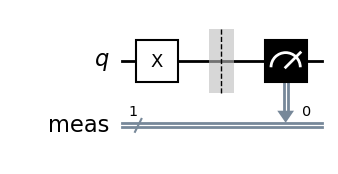

In [42]:
cal1 = QuantumCircuit(1)
cal1.x(0)
cal1.measure_all()
cal1.draw("mpl", style="bw")

In [43]:
counts = simulator.run([cal0, cal1], shots=shots).result().get_counts()
counts

[{'1': 1022, '0': 8978}, {'1': 7959, '0': 2041}]

In [44]:
for count_dict in counts:
    count_dict["0"] = count_dict["0"] / shots
    count_dict["1"] = count_dict["1"] / shots

counts

[{'1': 0.1022, '0': 0.8978}, {'1': 0.7959, '0': 0.2041}]

In [45]:
A_1q = [[counts[0]["0"], counts[1]["0"]], [counts[0]["1"], counts[1]["1"]]]
A_1q

[[0.8978, 0.2041], [0.1022, 0.7959]]

### Obtain the ideal and noisy expectation values

#### Ideal expectation value

In [46]:
counts_ideal = AerSimulator().run(qc, shots=shots).result().get_counts()

for key, val in counts_ideal.items():
    counts_ideal[key] = val / shots

counts_ideal

{'0000': 1.0}

In [47]:
ideal_expval = {}

for obs in observables:
    expval = sampled_expectation_value(counts_ideal, SparsePauliOp(obs))
    ideal_expval[obs] = expval

ideal_expval

{'ZIII': 1.0,
 'IZII': 1.0,
 'IIZI': 1.0,
 'IIIZ': 1.0,
 'ZZII': 1.0,
 'IZZI': 1.0,
 'IIZZ': 1.0,
 'ZZZI': 1.0,
 'IZZZ': 1.0,
 'ZZZZ': 1.0}

#### Noisy expectation value

In [48]:
counts_noisy = simulator.run(qc, shots=shots).result().get_counts()

for key, val in counts_noisy.items():
    counts_noisy[key] = val / shots

counts_noisy

{'1011': 0.0003,
 '1111': 0.0001,
 '1101': 0.001,
 '0111': 0.0013,
 '1010': 0.0079,
 '1001': 0.0078,
 '0101': 0.0095,
 '0011': 0.0093,
 '0001': 0.0768,
 '0110': 0.0085,
 '1100': 0.0079,
 '0100': 0.0731,
 '0010': 0.0713,
 '0000': 0.6502,
 '1110': 0.0008,
 '1000': 0.0742}

In [49]:
noisy_expval = {}

for obs in observables:
    expval = sampled_expectation_value(counts_noisy, SparsePauliOp(obs))
    noisy_expval[obs] = expval

noisy_expval

{'ZIII': 0.7999999999999998,
 'IZII': 0.7956000000000003,
 'IIZI': 0.8010000000000002,
 'IIIZ': 0.7878000000000003,
 'ZZII': 0.6348000000000003,
 'IZZI': 0.6394000000000002,
 'IIZZ': 0.6328,
 'ZZZI': 0.5078,
 'IZZZ': 0.5076,
 'ZZZZ': 0.4024}

### Invert the A matrix and perform mitigation

First we need to build the full A matrix: $A = A_{n-1} \otimes A_{n-2} \otimes ... \otimes A_0$

In [59]:
A = kron(A_1q, kron(A_1q, kron(A_1q, A_1q)))
A.shape

(16, 16)

In [51]:
diag(A)

array([0.64970828, 0.57596661, 0.57596661, 0.51059459, 0.57596661,
       0.51059459, 0.51059459, 0.45264228, 0.57596661, 0.51059459,
       0.51059459, 0.45264228, 0.51059459, 0.45264228, 0.45264228,
       0.40126753])

In [60]:
A_inv = inv(A)
A_inv.shape

(16, 16)

In [53]:
diag(A_inv)

array([1.73279522, 1.954647  , 1.954647  , 2.20490272, 1.954647  ,
       2.20490272, 2.20490272, 2.48719897, 1.954647  , 2.20490272,
       2.20490272, 2.48719897, 2.20490272, 2.48719897, 2.48719897,
       2.80563794])

In [54]:
list_counts_noisy = array(
    [counts_noisy[key] for key in sorted(list(counts_noisy.keys()))]
)

mitigated_counts_list = dot(A_inv, list_counts_noisy)
mitigated_counts_list

array([ 1.00110196e+00,  4.56242752e-03, -5.46130955e-03,  2.09554307e-03,
       -2.05562313e-03,  1.70080992e-03,  1.01646478e-03,  2.11130669e-04,
        1.02615312e-03, -1.69471077e-03, -9.31976560e-05, -1.53686220e-03,
       -9.03541390e-04,  1.54700672e-04, -2.52929453e-04,  1.28987928e-04])

In [55]:
mitigated_counts = {}

for idx, key in enumerate(sorted(list(counts_noisy.keys()))):
    mitigated_counts[key] = mitigated_counts_list[idx]

mitigated_counts

{'0000': np.float64(1.0011019564612844),
 '0001': np.float64(0.004562427517279338),
 '0010': np.float64(-0.0054613095465485114),
 '0011': np.float64(0.002095543066366553),
 '0100': np.float64(-0.0020556231328396966),
 '0101': np.float64(0.0017008099243328726),
 '0110': np.float64(0.0010164647814663308),
 '0111': np.float64(0.00021113066918026867),
 '1000': np.float64(0.0010261531223172363),
 '1001': np.float64(-0.0016947107663437251),
 '1010': np.float64(-9.31976559870861e-05),
 '1011': np.float64(-0.0015368621983684885),
 '1100': np.float64(-0.0009035413895159007),
 '1101': np.float64(0.00015470067230743744),
 '1110': np.float64(-0.0002529294529203081),
 '1111': np.float64(0.00012898792798901376)}

In [56]:
sum(list(mitigated_counts.values()))

np.float64(0.9999999999999999)

In [57]:
mitigated_expval = {}

for obs in observables:
    expval = sampled_expectation_value(mitigated_counts, SparsePauliOp(obs))
    mitigated_expval[obs] = expval

mitigated_expval

{'ZIII': 1.0063427994810434,
 'IZII': 0.9999999999999996,
 'IIZI': 1.0077843448176445,
 'IIIZ': 0.9887559463745136,
 'ZZII': 1.0028516705124841,
 'IZZI': 1.0121989605205057,
 'IIZZ': 1.000135489052827,
 'ZZZI': 1.009026157715293,
 'IZZZ': 1.0106116727535728,
 'ZZZZ': 1.0067046246991855}

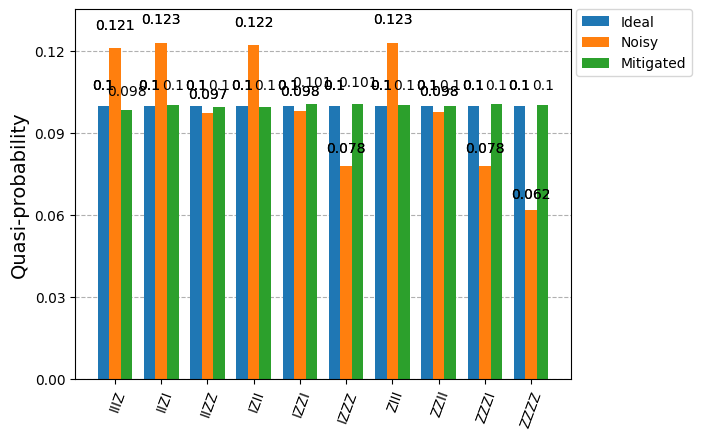

In [58]:
plot_histogram(
    [ideal_expval, noisy_expval, mitigated_expval],
    legend=["Ideal", "Noisy", "Mitigated"],
)